In [324]:
import sys
sys.path.append('./data_generated_library')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import credit_card_data

import torch.nn as nn
import torch
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt

from tqdm import tqdm
from random import shuffle

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
window_size = 12

Z,Y = credit_card_data.generate_raw_data(60, 10000)
train_data, train_label, test_data, test_label = credit_card_data.generate_win_data(Z, Y, window_size,future = 3)
train_data = torch.tensor(train_data, dtype=torch.float)
train_label = torch.tensor(train_label, dtype=torch.float)
test_data = torch.tensor(test_data, dtype=torch.float)
test_label = torch.tensor(test_label, dtype=torch.float)

In [13]:
print(train_label.size())
print(train_label.sum())

torch.Size([50928])
tensor(9143.)


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.batch_size = batch_size
        self.cnn1 = nn.Sequential(
            nn.Conv1d(
                in_channels = 1,
                out_channels = 5,
                kernel_size = 3
            )
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(
                in_channels = 5,
                out_channels = 5,
                kernel_size = 3
            )
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(
                in_channels = 5,
                out_channels = 5,
                kernel_size = 3
            ))
        self.cnn4 = nn.Sequential(
            nn.Conv1d(
                in_channels = 5,
                out_channels = 5,
                kernel_size = 3
            ))
        self.linear = nn.Linear(5,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        x = self.cnn1(input);print(x.size())
        x = self.cnn2(x);print(x.size())
        x = self.cnn3(x);print(x.size())
        x = self.cnn4(x);print(x.size())
        x = torch.squeeze(x);print(x.size())
        linear_out = self.linear(x)
        y_pred = self.sigmoid(linear_out)
        return y_pred

In [219]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        #print(a)
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [220]:
class LSTM(nn.Module):
    def __init__(self, batch_size, output_dim=3):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 3
        self.batch_size = batch_size
        self.num_layers = 2
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        # ("input size: ", input.size())
        lstm_out, hidden = self.lstm(input.view(input.size()[0],input.size()[1],-1))
        y_pred = self.linear(lstm_out[-1])
        y_pred = self.sigmoid(y_pred)
        return y_pred

In [313]:
class LSTM_ATT(nn.Module):
    def __init__(self, batch_size, seq_len, att_dim, output_dim=3,option = '1'):
        super(LSTM_ATT, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 4
        self.batch_size = batch_size
        self.num_layers = 2
        self.seq_len = seq_len
        self.att_dim = att_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.att = Attention(self.att_dim,5)
        self.linear_1 = nn.Linear(self.hidden_dim, output_dim)
        self.linear_2 = nn.Linear(self.att_dim, output_dim)
        self.linear_3 = nn.Linear(self.hidden_dim*self.seq_len,output_dim)
        self.sigmoid = nn.Sigmoid()
        self.option = option
    
    def forward(self, input):
        #print("input size: ", input.size())
        lstm_out, hidden = self.lstm(input.view(input.size()[0],input.size()[1],-1))#;print(lstm_out.size())
        output_1 = self.linear_1(lstm_out[-1])#;print(output_1.size())
        att_out = self.att(lstm_out[-5:].permute(1,0,2))#;print(att_out.size())
        output_2 = self.linear_2(att_out)#;print(output_2.size())
        output_3 = self.linear_3(lstm_out.view(input.size()[1],-1))
        
        y_pred_1 = self.sigmoid(output_1)
        y_pred_2 = self.sigmoid(output_2)
        y_pred_3 = self.sigmoid(output_3)
        if self.option == '1':
            y_pred = y_pred_1
        elif self.option == '2':
            y_pred = y_pred_2
        elif self.option == '3':
            y_pred = 0.5*y_pred_1 + 0.5*y_pred_2#;print(y_pred.size())
        return y_pred

In [314]:
len(train_data)//batch_size

99

In [315]:
def criteria(y_test, test_label):
    recall = []
    precision = []
    for t in range(10000):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        threshold = t*0.0001
        TP += ((y_test > threshold).numpy().flatten()&(test_label == 1).numpy()).sum()
        TN += ((y_test < threshold).numpy().flatten()&(test_label == 0).numpy()).sum()
        FP += ((y_test > threshold).numpy().flatten()&(test_label == 0).numpy()).sum()
        FN += ((y_test < threshold).numpy().flatten()&(test_label == 1).numpy()).sum()
        recall.append((TP) / (TP + FN))
        precision.append((TP) / (TP + FP))
    return recall, precision

In [326]:
batch_size = 512
num_epochs = 10

lstm_input_size = window_size
h1 = 4
num_train = len(train_data)
att_dim = 4
output_dim = 1
num_layers = 1
# model = LSTM(batch_size=batch_size, output_dim=output_dim)
# model.to(device)
model = LSTM_ATT(batch_size=batch_size, 
                 seq_len = window_size,
                 att_dim = att_dim,
                 output_dim=output_dim,
                 option = '1')
model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [327]:
for t in range(num_epochs):
    train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)
    shuffle(train)
    train_data_ = torch.tensor(train[:,:window_size])
    train_label_ = torch.tensor(train[:,window_size])
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimizer.zero_grad()
        batch_data = train_data_[i*batch_size:(i+1)*batch_size].permute(1,0).cuda()
        batch_label = train_label_[i*batch_size:(i+1)*batch_size].cuda()
        y_pred = model(batch_data)
        weight = 5 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(total_loss)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


tensor(129.4973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(120.7170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118.2525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118.6396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(119.1107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(119.2611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(119.2171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118.8967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118.9988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(120.1176, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


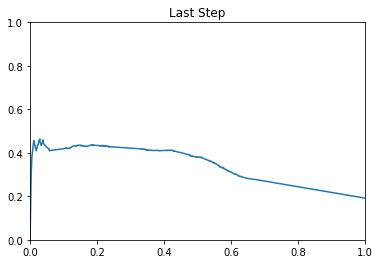

In [328]:
y_test = model(test_data.permute(1,0).cuda()).cpu()
recall1, precision1 = criteria(y_test, test_label)
plt.plot(recall1, precision1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Last Step')
plt.show()


C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


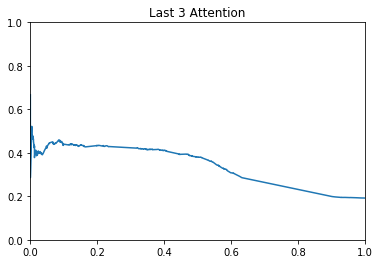

In [329]:
batch_size = 512
num_epochs = 3

lstm_input_size = window_size
h1 = 4
num_train = len(train_data)
att_dim = 4
output_dim = 1
num_layers = 1
# model = LSTM(batch_size=batch_size, output_dim=output_dim)
# model.to(device)
model = LSTM_ATT(batch_size=batch_size, 
                 seq_len = window_size,
                 att_dim = att_dim,
                 output_dim=output_dim,
                 option = '2')
model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(num_epochs):
    train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)
    shuffle(train)
    train_data_ = torch.tensor(train[:,:window_size])
    train_label_ = torch.tensor(train[:,window_size])
    for i in range(len(train_data)//batch_size):
        optimizer.zero_grad()
        batch_data = train_data_[i*batch_size:(i+1)*batch_size].permute(1,0).cuda()
        batch_label = train_label_[i*batch_size:(i+1)*batch_size].cuda()
        y_pred = model(batch_data)
        weight = 5 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        loss.backward()
        optimizer.step()
y_test = model(test_data.permute(1,0).cuda()).cpu()
recall2, precision2 = criteria(y_test, test_label)
plt.plot(recall2, precision2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Last 3 Attention')
plt.show()


C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


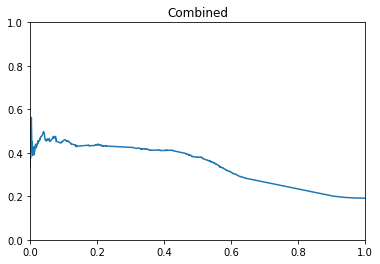

In [330]:
batch_size = 512
num_epochs = 3

lstm_input_size = window_size
h1 = 4
num_train = len(train_data)
att_dim = 4
output_dim = 1
num_layers = 1
# model = LSTM(batch_size=batch_size, output_dim=output_dim)
# model.to(device)
model = LSTM_ATT(batch_size=batch_size, 
                 seq_len = window_size,
                 att_dim = att_dim,
                 output_dim=output_dim,
                 option = '3')
model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(num_epochs):
    train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)
    shuffle(train)
    train_data_ = torch.tensor(train[:,:window_size])
    train_label_ = torch.tensor(train[:,window_size])
    for i in range(len(train_data)//batch_size):
        optimizer.zero_grad()
        batch_data = train_data_[i*batch_size:(i+1)*batch_size].permute(1,0).cuda()
        batch_label = train_label_[i*batch_size:(i+1)*batch_size].cuda()
        y_pred = model(batch_data)
        weight = 5 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        loss.backward()
        optimizer.step()
y_test = model(test_data.permute(1,0).cuda()).cpu()
recall3, precision3 = criteria(y_test, test_label)
plt.plot(recall3, precision3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Combined')
plt.show()


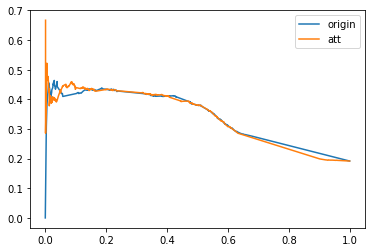

In [331]:
plt.plot(recall1, precision1,label = 'origin')
plt.plot(recall2, precision2,label = 'att')
# plt.plot(recall3, precision3,label = 'combine')
plt.legend()
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.show()
